In [1]:
import tensorflow as tf
import kerastuner
import matplotlib.pyplot as plt

C:\Users\Admin\AppData\Local\Temp\ipykernel_4048\235285264.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner


In [2]:
tf.__version__

'2.12.0'

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [4]:
x_train.shape

(60000, 28, 28)

In [5]:
set(y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

The label include from 0 to 9. 

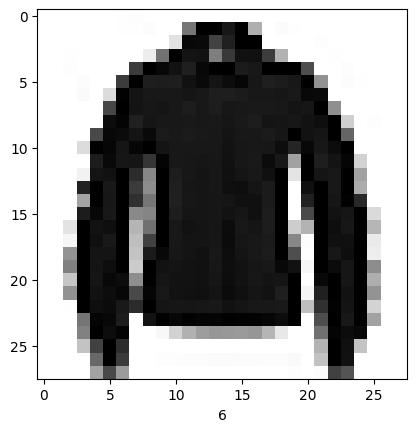

In [6]:
# Look at how images look like
plt.imshow(x_train[502], cmap="binary")
plt.xlabel(y_train[502])
plt.show()

### Create the model

In [8]:
def create_model(hp):

    num_hidden_layers = 1
    num_units = 8
    dropout_rate = 0.1
    learning_rate = 0.01

    if hp:
        num_hidden_layers = hp.Choice('num_hidden_layers', values=[1,2,3])
        num_units = hp.Choice('num_units', values=[8,16,32])
        dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5)
        learning_rate = hp.Float('learning_rate', min_value=0.0001, max_value=0.01)

    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Flatten(input_shape=(28,28)))
    model.add(tf.keras.layers.Lambda(lambda x: x/255.)) # This line we will normalize the input, because there is a value from 0 to 255 in each pixel so we should divide by 255.

    for i in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_units, activation="relu"))
        model.add(tf.keras.layers.Dropout(dropout_rate))
    
    model.add(tf.keras.layers.Dense(10, activation="softmax"))

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer =tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    return model

In [9]:
create_model(None).summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 lambda (Lambda)             (None, 784)               0         
                                                                 
 dense (Dense)               (None, 8)                 6280      
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 10)                90        
                                                                 
Total params: 6,370
Trainable params: 6,370
Non-trainable params: 0
_________________________________________________________________


In [10]:
class CustomTuner(kerastuner.tuners.BayesianOptimization):
    def run_trial(self, trial, *args, **kwargs):
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 128, step=32)
        return super(CustomTuner, self).run_trial(trial, *args, **kwargs)

In [11]:
tuner = CustomTuner(
    create_model, 
    objective='val_accuracy',
    max_trials=20,
    directory='logs',
    project_name='fashion_mnist',
    overwrite=True
)

In [12]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_hidden_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}
num_units (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32], 'ordered': True}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': None, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'linear'}


In [13]:
tuner.search(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=5, verbose=False
)

INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary(1)

Results summary
Results in logs\fashion_mnist
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 17 summary
Hyperparameters:
num_hidden_layers: 1
num_units: 32
dropout_rate: 0.1
learning_rate: 0.005397909735124323
batch_size: 128
Score: 0.862500011920929


In [ ]:
model = tuner.get_best_models(num_models=1)[0]
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 lambda (Lambda)             (None, 784)               0         
                                                                 
 dense (Dense)               (None, 32)                25120     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


In [ ]:
_ = model.fit(
    x_train, y_train,
    validation_data=(x_test,y_test),
    epochs=20, batch_size=128,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
)

Epoch 1/20
469/469 [==============================] - 3s 5ms/step - loss: 0.3706 - accuracy: 0.8629 - val_loss: 0.3856 - val_accuracy: 0.8604
Epoch 2/20
469/469 [==============================] - 2s 4ms/step - loss: 0.3634 - accuracy: 0.8651 - val_loss: 0.3834 - val_accuracy: 0.8637
Epoch 3/20
469/469 [==============================] - 2s 4ms/step - loss: 0.3580 - accuracy: 0.8674 - val_loss: 0.3904 - val_accuracy: 0.8623
Epoch 4/20
469/469 [==============================] - 2s 4ms/step - loss: 0.3512 - accuracy: 0.8694 - val_loss: 0.3836 - val_accuracy: 0.8656
Epoch 5/20
469/469 [==============================] - 2s 4ms/step - loss: 0.3481 - accuracy: 0.8710 - val_loss: 0.3912 - val_accuracy: 0.8633
Epoch 6/20
469/469 [==============================] - 2s 4ms/step - loss: 0.3385 - accuracy: 0.8722 - val_loss: 0.3864 - val_accuracy: 0.8600
Epoch 7/20
469/469 [==============================] - 2s 4ms/step - loss: 0.3379 - accuracy: 0.8746 - val_loss: 0.3779 - val_accuracy: 0.8672
Epoch 